# A. Informationen zum Notebook

<p>Herausgeber: Koordinierungsstelle Bildungsmonitoring (KOSMO)</p>
<p>Version: X.X.X (XX.XX.2023)<p/>
<p>DOI: XXX</p>
<p>Dieses Notebook dient dazu, Gemeindedaten der Bundesagentur fuer Arbeit (BA) mit Bevoelkerungsdaten des Statistischen Bundesamtes (Destatis) zu verknuepfen, um daraus gemeindespezifische SGB-II-Quoten berechnen zu koennen. Hierbei wird auf folgende Originaldaten der BA und von Destatis zugegriffen, die von den entsprechenden Stellen bezogen werden koennen: </p>

- Genaue Zitation BA-Daten
- Genaue Zitation Destatis-Daten

Um die Aufbereitung der Daten korrekt durchfuehren zu koennen, muessen diese Notebook-Datei (.ipynb) sowie die Originaldaten bzw. -dateien der BA und von Destatis in einem lokalen Ordner gespeichert werden.

# 0. Vorbereitung der Daten

In [1]:
# Benoetigte Pakete importieren
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Hinweis: die folgende Bibliothek muss manuell installiert werden
from mapclassify import NaturalBreaks
from mapclassify import FisherJenksSampled

In [2]:
# Begrenzung der Spaltendarstellung deaktivieren
pd.set_option("display.max_columns", None)

In [3]:
# Einlesen der Gemeindedaten der Bundesagentur fuer Arbeit (BA) aus den Jahren 2014 bis 2021

# Dateinamen und Tabellennamen abrufen
file_names = [
    ("230328_EA_338634_Gemeindedaten_Teil1.xlsx", "2014"),
    ("230328_EA_338634_Gemeindedaten_Teil2.xlsx", "2015"),
    ("230328_EA_338634_Gemeindedaten_Teil2.xlsx", "2016"),
    ("230328_EA_338634_Gemeindedaten_Teil3.xlsx", "2017"),
    ("230328_EA_338634_Gemeindedaten_Teil3.xlsx", "2018"),
    ("230328_EA_338634_Gemeindedaten_Teil4.xlsx", "2019"),
    ("230328_EA_338634_Gemeindedaten_Teil4.xlsx", "2020"),
    ("230328_EA_338634_Gemeindedaten_Teil5.xlsx", "2021")
]

# Dictionary fuer die Dataframes erstellen
dataframes = {}

# Ueber Dateien und Tabellennamen iterieren
for file_name, sheet_name in file_names:
    # Spezifisches Tabellenblatt in einen DataFrame einlesen
    df = pd.read_excel(file_name, sheet_name=sheet_name)
    # DataFrame im Dictionary speichern
    dataframes["ba_" + sheet_name] = df

# Zugriff auf die Dataframes
ba_2014 = dataframes["ba_2014"]
ba_2015 = dataframes["ba_2015"]
ba_2016 = dataframes["ba_2016"]
ba_2017 = dataframes["ba_2017"]
ba_2018 = dataframes["ba_2018"]
ba_2019 = dataframes["ba_2019"]
ba_2020 = dataframes["ba_2020"]
ba_2021 = dataframes["ba_2021"]

In [4]:
# Daten (Beispiel 2021) inspizieren
ba_2021.head(20)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Grundsicherung für Arbeitsuchende (SGB II)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eckwerte der Grundsicherung nach Gemeinden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Deutschland - Gemeinden (Gebietsstand Dezember...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Jahresdurchschnitt 2021, Datenstand: März 2023",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Daten zu Leistungen nach dem SGB II nach einer...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Gemeinde,Leistungs-berechtigte (LB),Insgesamt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,darunter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Männer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Frauen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,dar. (Sp. 1) im Alter von ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dar. (Sp. 1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leistungs-berechtigte (LB),dar. (Sp. 25) im Alter von ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dar. (Sp

# 1. BA-Daten umformen

### 1.1 Grundlegende Umformung der Ausgangsdaten

In [5]:
# Funktion zur Transformation der Daten definieren
def transform_dataframe(df):
    # Zeilen 0 bis 7 entfernen
    df = df.drop(df.index[0:7])
    
    # Letzte Zeile entfernen
    df = df.drop(df.index[-1])
    
    # Spalte 'Unnamed: 0' nach Leerzeichen trennen und in neue Spalten 'AGS' und 'Gemeinde' aufteilen
    df[['AGS', 'Gemeinde']] = df['Unnamed: 0'].str.split(' ', 1, expand=True)
    
    # Spalte 'Unnamed: 0' entfernen
    df = df.drop(['Unnamed: 0'], axis=1)
    
    # Erstellen einer Kontrollspalte 'Gesamtwerte_Kontrolle' mit den Spalten 'AGS', 'Gemeinde' und 'Unnamed: 1'
    Gesamtwerte_Kontrolle = df[['AGS', 'Gemeinde', 'Unnamed: 1']].copy()
    
    # Spalte 'Unnamed: 1' entfernen
    df.drop(['Unnamed: 1'], axis=1, inplace=True)
    
    # Nur Spalten ab der 23. Spalte behalten
    df = df.iloc[:, 23:]
    
    # Fehlende Werte in Zeile 5 mit den Werten der vorherigen Zeilen fuellen
    df.iloc[5] = df.iloc[5].fillna(df.iloc[4])
    df.iloc[5] = df.iloc[5].fillna(df.iloc[3])
    df.iloc[5] = df.iloc[5].fillna(df.iloc[2])
    
    # Zeilen 7, 9, 10, 11 und 13 entfernen
    df = df.drop([7, 9, 10, 11, 13])
    
    # Letzte beiden Werte in Zeile 1 mit den Werten der letzten beiden Spaltennamen fuellen
    df.iloc[1, -1] = df.columns[-1]
    df.iloc[1, -2] = df.columns[-2]
    
    # Neue Spaltennamen aus Zeile 1 erstellen
    new_columns = df.iloc[1].tolist()
    
    # Spaltennamen aktualisieren
    df = df.set_axis(new_columns, axis=1, inplace=False)
    
    # Zeile 12 entfernen
    df = df.drop(12)
    
    # Transformiertes DataFrame zurueckgeben
    return df

# Definierte Funktion auf die Daten anwenden und damit Dataframes erstellen
ba_2014 = transform_dataframe(ba_2014)
ba_2015 = transform_dataframe(ba_2015)
ba_2016 = transform_dataframe(ba_2016)
ba_2017 = transform_dataframe(ba_2017)
ba_2018 = transform_dataframe(ba_2018)
ba_2019 = transform_dataframe(ba_2019)
ba_2020 = transform_dataframe(ba_2020)
ba_2021 = transform_dataframe(ba_2021)

C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_23044\697503413.py:10: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['AGS', 'Gemeinde']] = df['Unnamed: 0'].str.split(' ', 1, expand=True)
C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_23044\697503413.py:40: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df = df.set_axis(new_columns, axis=1, inplace=False)
C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_23044\697503413.py:10: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['AGS', 'Gemeinde']] = df['Unnamed: 0'].str.split(' ', 1, expand=True)
C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_23044\697503413.py:40: FutureWarning: DataFrame.set_axis 'inplace' keyword is depre

In [6]:
# Daten (Beispiel 2018) inspizieren
ba_2018.head()

,Leistungs-berechtigte (LB),unter 65 Jahren,unter 15 Jahren,unter 3 Jahren,3 bis unter 6 Jahren,6 bis unter 15 Jahren,15 bis unter 18 Jahren,18 bis unter 25 Jahren,25 bis unter 65 Jahren,15 bis unter 18 Jahren (Kinder),Erwerbs-fähige Leistungs-berechtigte (ELB),erziehende ELB,allein-erziehende ELB,arbeit-suchende ELB insgesamt,kein Hauptschul-abschluss,Hauptschul-abschluss,mittlere Reife,Fachhoch-schule,Abitur/ Hochschul-reife,keine Angabe,ohne abge-schlossene Berufs-ausbildung,betriebliche/schulische Ausbildung,akade-mische Ausbildung,keine Angabe,Leistungs-berechtigte (LB),unter 65 Jahren,unter 15 Jahren,unter 3 Jahren,3 bis unter 6 Jahren,6 bis unter 15 Jahren,15 bis unter 18 Jahren,18 bis unter 25 Jahren,25 bis unter 65 Jahren,15 bis unter 18 Jahren (Kinder),Erwerbs-fähige Leistungs-berechtigte (ELB),erziehende ELB,allein-erziehende ELB,arbeit-suchende ELB insgesamt,kein Hauptschul-abschluss,Hauptschul-abschluss,mittlere Reife,Fachhoch-schule,Abitur/ Hochschul-reife,keine Angabe,ohne abge-schlossene Berufs-ausbildung,betriebliche/schulische Ausbildung,akade-mische Ausbildung,keine Angabe,AGS,Gemeinde
8,Männer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Frauen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,6128.666667,6117.916667,1561.5,378.75,341.166667,841.583333,229.75,741.666667,3585,219.833333,4499,949.25,101,3487.5,707.75,1321.833333,457.583333,210.416667,388.75,401.166667,2415.083333,903.083333,167.333333,2,5643.083333,5631.25,1571.833333,396.25,330.083333,845.5,208,676.666667,3174.75,199.083333,3974,1950.5,1077.666667,2442.583333,416.083333,933.5,396.5,88.75,223.666667,384.083333,1628.666667,724.333333,87.25,2.333333,01001000,"Flensburg, Stadt"
15,17856,17793.5,4702.666667,1010.416667,985.416667,2706.833333,771.916667,1870.083333,10448.833333,742.583333,12939.083333,3024.25,186.916667,9929.666667,2238.25,3303.833333,1309.166667,523.916667,1707.916667,846.583333,6687.333333,2449.666667,789.083333,3.583333,16340.416667,16293.666667,4562.416667,993.833333,930.833333,2637.75,707.083333,1609.75,9414.416667,677.25,11555.5,5476.583333,2516.083333,7028.583333,1520.166667,2319.166667,1166.75,315.666667,1036.666667,670.166667,4652.666667,1829.083333,542.833333,4,01002000,"Kiel, Landeshauptstadt"
16,13417.833333,13344.666667,3785.833333,824.083333,803.75,2158,599.583333,1231.583333,7727.666667,579.583333,9471.166667,2197.916667,163.25,7217.666667,1469.5,2749.333333,961.416667,380.416667,574.75,1082.25,4873.916667,2011.75,329.333333,2.666667,12890,12834.166667,3357.916667,693.25,717.666667,1947,543.416667,1218.5,7714.333333,524.583333,9347.25,4388.666667,2277.583333,5824.166667,1027.833333,2093.083333,1005.916667,252,491.416667,953.916667,3802.25,1756.75,263.333333,1.833333,01003000,"Lübeck, Hansestadt"
17,4778.916667,4760.5,1312.083333,280.666667,284.833333,746.583333,216.833333,506.75,2724.833333,210.25,3358.583333,804,65,2581.916667,605.75,1091.916667,284,77.333333,147.666667,375.25,1870.25,656.75,54.416667,0.5,4680.833333,4658.583333,1295.916667,264.583333,287.666667,743.666667,171,553.25,2638.416667,160.5,3284.25,1630.333333,874.666667,2077.083333,454.083333,889.833333,256.083333,34.416667,98.25,344.416667,1543.5,494.416667,38.333333,0.833333,01004000,"Neumünster, Stadt"


### 1.2 Spalte fuer Geschlecht ergaenzen und Tabelle entsprechend stapeln

In [7]:
# Funktion zur Transformation der Daten definieren
def apply_transformation(df):
    # Daten (maennlich) aus den ersten 24 Spalten und den Spalten 48 und 49 extrahieren
    df_m = df.iloc[:, list(range(24)) + [48, 49]]
    
    # Daten (weiblich) aus den Spalten 24 bis 49 extrahieren
    df_w = df.iloc[:, 24:50]
    
    # Geschlecht fuer Daten (weiblich) auf "w" setzen
    df_w.loc[:, "Geschlecht"] = "w"
    
    # Geschlecht fuer Daten (maennlich) auf "m" setzen
    df_m.loc[:, "Geschlecht"] = "m"
    
    # Zeile 8 aus Daten (weiblich) entfernen
    df_w = df_w.drop([8])
    
    # Zeile 8 aus Daten (maennlich) entfernen
    df_m = df_m.drop([8])
    
    # Daten (maennlich und weiblich) zu einem DataFrame kombinieren
    combined_df = df_m.append(df_w, ignore_index=True)
    
    # Spalten umbenennen, indem Bindestriche "-" entfernt werden
    combined_df = combined_df.rename(columns=lambda x: x.replace('-', ''))
    
    return combined_df

# Definierte Funktion auf die Daten anwenden und damit Dataframes transformieren
ba_2014_combined = apply_transformation(ba_2014)
ba_2015_combined = apply_transformation(ba_2015)
ba_2016_combined = apply_transformation(ba_2016)
ba_2017_combined = apply_transformation(ba_2017)
ba_2018_combined = apply_transformation(ba_2018)
ba_2019_combined = apply_transformation(ba_2019)
ba_2020_combined = apply_transformation(ba_2020)
ba_2021_combined = apply_transformation(ba_2021)

C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_23044\787215793.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w.loc[:, "Geschlecht"] = "w"
C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_23044\787215793.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m.loc[:, "Geschlecht"] = "m"
C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_23044\787215793.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat i

In [8]:
# Daten (Beispiel 2014) inspizieren
ba_2014_combined.head()

,Leistungsberechtigte (LB),unter 65 Jahren,unter 15 Jahren,unter 3 Jahren,3 bis unter 6 Jahren,6 bis unter 15 Jahren,15 bis unter 18 Jahren,18 bis unter 25 Jahren,25 bis unter 65 Jahren,15 bis unter 18 Jahren (Kinder),Erwerbsfähige Leistungsberechtigte (ELB),erziehende ELB,alleinerziehende ELB,arbeitsuchende ELB insgesamt,kein Hauptschulabschluss,Hauptschulabschluss,mittlere Reife,Fachhochschule,Abitur/ Hochschulreife,keine Angabe,ohne abgeschlossene Berufsausbildung,betriebliche/schulische Ausbildung,akademische Ausbildung,keine Angabe,AGS,Gemeinde,Geschlecht
0,5243.25,5236.416667,1198.083333,273.666667,236.833333,687.583333,198.25,576.333333,3263.75,193,3956.25,697.666667,84.75,3215.666667,564.083333,1606.083333,472,174.583333,174,224.916667,1984.5,1101.75,87.75,41.666667,01001000,"Flensburg, Stadt",m
1,16628.916667,16599.75,4059.833333,888.333333,834.25,2337.25,684.75,1519.333333,10335.833333,670.166667,12245.083333,2532.166667,177.166667,9485.75,1735.083333,4051.833333,1469.75,509.5,1110.916667,608.666667,5776.25,3057.75,533.5,118.25,01002000,"Kiel, Landeshauptstadt",m
2,13740.583333,13711.583333,3487,745.166667,707.583333,2034.25,588.916667,1278.916667,8356.75,579.583333,10053.916667,2136.166667,160.166667,7943.333333,1408.916667,3825.75,1176.25,394.5,453.083333,684.833333,4916.416667,2600.833333,241.333333,184.75,01003000,"Lübeck, Hansestadt",m
3,5154.416667,5144.416667,1287.083333,268.833333,241.25,777,242.5,501.333333,3113.5,236.166667,3761.916667,843.333333,78.5,2972.75,653.25,1499.5,339.916667,71.583333,116.833333,291.666667,1914.166667,963.916667,41.75,52.916667,01004000,"Neumünster, Stadt",m
4,198,197,57.666667,17,7.166667,33.5,4.25,18.083333,117,4.25,136.5,27.5,1.166667,110.25,24.083333,60.25,13.083333,2.25,4.416667,6.166667,56.583333,51.5,1.833333,0.333333,01051001,Albersdorf,m


### 1.3 Gestapelte Zieltabellen erstellen:

 - Ein Dataframe (DF) mit Leistungsberechtigten (LB) nach Geschlecht und Altersgruppen, das sich auf Anzahl der LB aggregieren laesst
     - Spalte "LB unter 15 Jahren" loeschen, da aus anderen Spalten summierbar
     - Spalte "LB unter 65 Jahren" loeschen, da aus anderen Spalten summierbar 
     - Spalte "15 bis unter 18 Jahren (Kinder)" loeschen
 - Ein DF mit arbeitssuchenden erwerbsfaehigen Leistungsberechtigten (ELB) nach Geschlecht und Schulabschluessen (Unterscheidung Schulabschluesse nur fuer "arbeitssuchende ELB" moeglich)
     - Spalten 15 - 20 in der Ausgangsdatei
 - Ein DF mit arbeitssuchenden ELB nach Geschlecht und Berufsausbildung (Unterscheidung Berufsausbildung nur fuer "arbeitssuchende ELB" moeglich)
     - Spalten 21- 24 in der Ausgangsdatei

In [9]:
print(ba_2014_combined.columns)

Index(['Leistungsberechtigte (LB)', 'unter 65 Jahren', 'unter 15 Jahren',
       'unter 3 Jahren', '3 bis unter 6 Jahren', '6 bis unter 15 Jahren',
       '15 bis unter 18 Jahren', '18 bis unter 25 Jahren',
       '25 bis unter 65 Jahren', '15 bis unter 18 Jahren (Kinder)',
       'Erwerbsfähige Leistungsberechtigte (ELB)', 'erziehende ELB',
       'alleinerziehende ELB', 'arbeitsuchende ELB insgesamt',
       'kein Hauptschulabschluss', 'Hauptschulabschluss', 'mittlere Reife',
       'Fachhochschule', 'Abitur/ Hochschulreife', 'keine Angabe',
       'ohne abgeschlossene Berufsausbildung',
       'betriebliche/schulische Ausbildung', 'akademische Ausbildung',
       'keine Angabe', 'AGS', 'Gemeinde', 'Geschlecht'],
      dtype='object')


In [10]:
# Funktion zur Transformation der Daten definieren
def apply_transformation(df, year):
    # relevante Spalten aus dem kombinierten Dataframe extrahieren
    LB_nach_Altersgruppen = df.iloc[:, [3, 4, 5, 6, 7, 8, 24, 25, 26]].copy()

    # Datensatz in langes Format umwandeln, indem Altersgruppen in separate Spalte transformiert werden
    LB_nach_Altersgruppen = pd.melt(LB_nach_Altersgruppen, id_vars=['AGS', 'Gemeinde', 'Geschlecht'], value_vars=['unter 3 Jahren', '3 bis unter 6 Jahren', '6 bis unter 15 Jahren', '15 bis unter 18 Jahren', '18 bis unter 25 Jahren', '25 bis unter 65 Jahren'], var_name='Altersgruppe', value_name='Anzahl')

    # Spalte hinzufuegen, um das Jahr zu speichern
    LB_nach_Altersgruppen['Jahr'] = year

    # Spalten "AGS" und "Jahr" in Ganzzahlen umwandeln
    LB_nach_Altersgruppen["AGS"] = pd.to_numeric(LB_nach_Altersgruppen["AGS"], downcast="integer")
    LB_nach_Altersgruppen["Jahr"] = pd.to_numeric(LB_nach_Altersgruppen["Jahr"], downcast="integer")

    # gleicher Vorgang fuer arbeitssuchende ELB nach Schulabschluessen
    ELB_arbeitssuchend_nach_Schulabschluessen = df.iloc[:, [13, 14, 15, 16, 17, 18, 19, 24, 25, 26]].copy()
    ELB_arbeitssuchend_nach_Schulabschluessen = pd.melt(ELB_arbeitssuchend_nach_Schulabschluessen, id_vars=['AGS', 'Gemeinde', 'Geschlecht', 'arbeitsuchende ELB insgesamt'], value_vars=['kein Hauptschulabschluss', 'Hauptschulabschluss', 'mittlere Reife', 'Fachhochschule', 'Abitur/ Hochschulreife', 'keine Angabe'], var_name='Schulabschluss', value_name='Anzahl')
    ELB_arbeitssuchend_nach_Schulabschluessen['Jahr'] = year
    ELB_arbeitssuchend_nach_Schulabschluessen["AGS"] = pd.to_numeric(ELB_arbeitssuchend_nach_Schulabschluessen["AGS"], downcast="integer")
    ELB_arbeitssuchend_nach_Schulabschluessen["Jahr"] = pd.to_numeric(ELB_arbeitssuchend_nach_Schulabschluessen["Jahr"], downcast="integer")

    # gleicher Vorgang fuer die ELB arbeitssuchend nach Berufsausbildung
    ELB_arbeitssuchend_nach_Berufsausbildung = df.iloc[:, [13, 20, 21, 22, 23, 24, 25, 26]].copy()
    ELB_arbeitssuchend_nach_Berufsausbildung = pd.melt(ELB_arbeitssuchend_nach_Berufsausbildung, id_vars=['AGS', 'Gemeinde', 'Geschlecht', 'arbeitsuchende ELB insgesamt'], value_vars=['ohne abgeschlossene Berufsausbildung', 'betriebliche/schulische Ausbildung', 'akademische Ausbildung', 'keine Angabe'], var_name='Berufsausbildung', value_name='Anzahl')
    ELB_arbeitssuchend_nach_Berufsausbildung['Jahr'] = year
    ELB_arbeitssuchend_nach_Berufsausbildung["AGS"] = pd.to_numeric(ELB_arbeitssuchend_nach_Berufsausbildung["AGS"], downcast="integer")
    ELB_arbeitssuchend_nach_Berufsausbildung["Jahr"] = pd.to_numeric(ELB_arbeitssuchend_nach_Berufsausbildung["Jahr"], downcast="integer")

    # Rueckgabe der Ergebnisse in separaten Dataframes
    return LB_nach_Altersgruppen, ELB_arbeitssuchend_nach_Schulabschluessen, ELB_arbeitssuchend_nach_Berufsausbildung

# Definierte Funktion auf die Daten anwenden und damit Dataframes transformieren
LB_nach_Altersgruppen_2014, ELB_arbeitssuchend_nach_Schulabschluessen_2014, ELB_arbeitssuchend_nach_Berufsausbildung_2014 = apply_transformation(ba_2014_combined, 2014)
LB_nach_Altersgruppen_2015, ELB_arbeitssuchend_nach_Schulabschluessen_2015, ELB_arbeitssuchend_nach_Berufsausbildung_2015 = apply_transformation(ba_2015_combined, 2015)
LB_nach_Altersgruppen_2016, ELB_arbeitssuchend_nach_Schulabschluessen_2016, ELB_arbeitssuchend_nach_Berufsausbildung_2016 = apply_transformation(ba_2016_combined, 2016)
LB_nach_Altersgruppen_2017, ELB_arbeitssuchend_nach_Schulabschluessen_2017, ELB_arbeitssuchend_nach_Berufsausbildung_2017 = apply_transformation(ba_2017_combined, 2017)
LB_nach_Altersgruppen_2018, ELB_arbeitssuchend_nach_Schulabschluessen_2018, ELB_arbeitssuchend_nach_Berufsausbildung_2018 = apply_transformation(ba_2018_combined, 2018)
LB_nach_Altersgruppen_2019, ELB_arbeitssuchend_nach_Schulabschluessen_2019, ELB_arbeitssuchend_nach_Berufsausbildung_2019 = apply_transformation(ba_2019_combined, 2019)
LB_nach_Altersgruppen_2020, ELB_arbeitssuchend_nach_Schulabschluessen_2020, ELB_arbeitssuchend_nach_Berufsausbildung_2020 = apply_transformation(ba_2020_combined, 2020)
LB_nach_Altersgruppen_2021, ELB_arbeitssuchend_nach_Schulabschluessen_2021, ELB_arbeitssuchend_nach_Berufsausbildung_2021 = apply_transformation(ba_2021_combined, 2021)

In [11]:
# Daten (Beispiel 2014) inspizieren
ELB_arbeitssuchend_nach_Schulabschluessen_2014.head(20)

,AGS,Gemeinde,Geschlecht,arbeitsuchende ELB insgesamt,Schulabschluss,Anzahl,Jahr
0,1001000,"Flensburg, Stadt",m,3215.666667,kein Hauptschulabschluss,564.083333,2014
1,1002000,"Kiel, Landeshauptstadt",m,9485.75,kein Hauptschulabschluss,1735.083333,2014
2,1003000,"Lübeck, Hansestadt",m,7943.333333,kein Hauptschulabschluss,1408.916667,2014
3,1004000,"Neumünster, Stadt",m,2972.75,kein Hauptschulabschluss,653.25,2014
4,1051001,Albersdorf,m,110.25,kein Hauptschulabschluss,24.083333,2014
5,1051002,Arkebek,m,3.583333,kein Hauptschulabschluss,1,2014
6,1051003,Averlak,m,1.75,kein Hauptschulabschluss,0.25,2014
7,1051004,Bargenstedt,m,11.583333,kein Hauptschulabschluss,4.75,2014
8,1051005,Barkenholm,m,3.25,kein Hauptschulabschluss,0,2014
9,1051006,Barlt,m,13.666667,kein Hauptschulabschluss,1.583333,2014


# 2. Bevoelkerungsdaten umformen



In [12]:
# Liste mit den Dateinamen erstellen
file_names = glob.glob('bevoelkerung_alter_geschlecht_*.csv')

# Schleife ueber alle Dateien
for file in file_names:
    # Jahreszahl aus dem Dateinamen extrahieren
    year = file.split('_')[-1].split('.')[0]

    # Daten einlesen und jede CSV in einem DataFrame mit der Bezeichnung "bevoelkerung_yyyy" speichern
    df_name = 'bevoelkerung_' + year
    globals()[df_name] = pd.read_csv(file, encoding='ISO-8859-1', delimiter=';')

    # Umwandlung der Spalte "Geschlecht"
    for df in [globals()[df_name]]:
        df['Geschlecht'] = df['Geschlecht'].astype(str)
        df['Geschlecht'] = df['Geschlecht'].replace({'2': 'w', '1': 'm'})

    # Umwandlung der Spalte "Alter"
    for df in [globals()[df_name]]:
        df['Alter'] = df['Alter'].replace({'u3': 'unter 3 Jahren', '3-u6': '3 bis unter 6 Jahren',
                                           '6-u15': '6 bis unter 15 Jahren', '15-u18': '15 bis unter 18 Jahren',
                                           '18-u25': '18 bis unter 25 Jahren', '25-u65': '25 bis unter 65 Jahren'})

    # Entfernung der Zeilen mit den Werten "u65" und "ue65" in der Spalte "Alter"
    for df in [globals()[df_name]]:
        df.drop(df[(df['Alter'] == 'u65') | (df['Alter'] == 'ü65') | (df['Alter'] == 'insg')].index, inplace=True)
    
    # Spaltennamen aendern      
    for df in [globals()[df_name]]:
        df.rename(columns={"Alter": "Altersgruppe", "Anzahl": "Anzahl_Bevoelkerung"}, inplace=True)

In [13]:
# Daten (Beispiel 2014) inspizieren
bevoelkerung_2014.head(10)

,AGS,Geschlecht,Altersgruppe,Anzahl_Bevoelkerung
1,1001000,m,unter 3 Jahren,1087.0
2,1001000,m,3 bis unter 6 Jahren,1054.0
3,1001000,m,6 bis unter 15 Jahren,3135.0
4,1001000,m,15 bis unter 18 Jahren,1163.0
5,1001000,m,18 bis unter 25 Jahren,4817.0
6,1001000,m,25 bis unter 65 Jahren,23068.0
10,1001000,w,unter 3 Jahren,1149.0
11,1001000,w,3 bis unter 6 Jahren,1013.0
12,1001000,w,6 bis unter 15 Jahren,2871.0
13,1001000,w,15 bis unter 18 Jahren,1117.0


# 3. Sozial- und Bevoelkerungsdaten zusammenfuegen ("Merge") und Quoten berechnen

## 3.1 Merge

In [14]:
# Vergleich der Datensaetze
LB_nach_Altersgruppen_2021.head()

,AGS,Gemeinde,Geschlecht,Altersgruppe,Anzahl,Jahr
0,1001000,"Flensburg, Stadt",m,unter 3 Jahren,359.333333,2021
1,1002000,"Kiel, Landeshauptstadt",m,unter 3 Jahren,852.5,2021
2,1003000,"Lübeck, Hansestadt",m,unter 3 Jahren,587.583333,2021
3,1004000,"Neumünster, Stadt",m,unter 3 Jahren,277.583333,2021
4,1051001,Albersdorf,m,unter 3 Jahren,6.083333,2021


In [15]:
bevoelkerung_2021.head()

,AGS,Geschlecht,Altersgruppe,Anzahl_Bevoelkerung
1,1001000,m,unter 3 Jahren,1430.0
2,1001000,m,3 bis unter 6 Jahren,1330.0
3,1001000,m,6 bis unter 15 Jahren,3559.0
4,1001000,m,15 bis unter 18 Jahren,1149.0
5,1001000,m,18 bis unter 25 Jahren,4983.0


In [16]:
# Listenuebersicht der Altersgruppen erstellen (kann spaeter geloescht werden)
LB_nach_Altersgruppen_2021['Altersgruppe'].unique()

array(['unter 3 Jahren', '3 bis unter 6 Jahren', '6 bis unter 15 Jahren',
       '15 bis unter 18 Jahren', '18 bis unter 25 Jahren',
       '25 bis unter 65 Jahren'], dtype=object)

In [17]:
# Listenuebersicht der Altersgruppen erstellen (kann spaeter geloescht werden)
bevoelkerung_2021['Altersgruppe'].unique()

array(['unter 3 Jahren', '3 bis unter 6 Jahren', '6 bis unter 15 Jahren',
       '15 bis unter 18 Jahren', '18 bis unter 25 Jahren',
       '25 bis unter 65 Jahren'], dtype=object)

### Plan fuer den Merge (hier fuer 2021, analog auch auf weitere Jahrgaenge uebertragbar):

- LB_nach_Altersgruppen_2021 und bevoelkerung_2021: 
    - Ziel: Anteil der LB (nach Altersgruppen und Geschlecht) an der jeweiligen Bevoelkerung berechnen
    - Vorbereitung: bevoelkerung_2021 gruppieren nach "AGS" und "Geschlecht", sodass Summe der u65 Jaehrigen gebildet wird fuer SGBII-Quote
    - Merge ueber die Spalten "AGS", "Geschlecht"
- ELB_arbeitssuchend_nach_Berufsausbildung_2021:
    - Ziel: Anteil der arbeitssuchenden ELB nach Berufsausbildung und Geschlecht an der Gesamtzahl der arbeitssuchenden ELB 15-u65 berechnen
    - Kein Merge mit Bevoelkerungsdaten erforderlich
- ELB_arbeitssuchend_nach_Schulabschluessen_2021:
    - Ziel: Anteil der arbeitssuchenden ELB nach Schulabschluss und Geschlecht an der Gesamtzahl der arbeitssuchenden ELB 15-u65 berechnen
    - Kein Merge mit Bevoelkerungsdaten erforderlich

In [18]:
# Merge der Dataframes fuer 2014

## LB
merged_lb_bev_2014 = LB_nach_Altersgruppen_2014.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])

# Merge der Dataframes fuer die uebrigen Jahre

## LB
merged_lb_bev_2015 = LB_nach_Altersgruppen_2015.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2016 = LB_nach_Altersgruppen_2016.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2017 = LB_nach_Altersgruppen_2017.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2018 = LB_nach_Altersgruppen_2018.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2019 = LB_nach_Altersgruppen_2019.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2020 = LB_nach_Altersgruppen_2020.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2021 = LB_nach_Altersgruppen_2021.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])

In [19]:
# Daten (Beispiel 2014) inspizieren

merged_lb_bev_2014.head()

,AGS,Gemeinde,Geschlecht,Altersgruppe,Anzahl,Jahr,Anzahl_Bevoelkerung
0,1001000,"Flensburg, Stadt",m,unter 3 Jahren,273.666667,2014,1087.0
1,1002000,"Kiel, Landeshauptstadt",m,unter 3 Jahren,888.333333,2014,3284.0
2,1003000,"Lübeck, Hansestadt",m,unter 3 Jahren,745.166667,2014,2802.0
3,1004000,"Neumünster, Stadt",m,unter 3 Jahren,268.833333,2014,954.0
4,1051001,Albersdorf,m,unter 3 Jahren,17,2014,54.0


### 3.2 Ergebnistabellen stapeln

In [20]:
stacked_lb_bev = pd.concat([merged_lb_bev_2014, merged_lb_bev_2015, merged_lb_bev_2016, merged_lb_bev_2017, merged_lb_bev_2018, merged_lb_bev_2019, merged_lb_bev_2020, merged_lb_bev_2021], ignore_index=True)
stacked_elb_schul = pd.concat([ELB_arbeitssuchend_nach_Schulabschluessen_2014, ELB_arbeitssuchend_nach_Schulabschluessen_2015, ELB_arbeitssuchend_nach_Schulabschluessen_2016, ELB_arbeitssuchend_nach_Schulabschluessen_2017, ELB_arbeitssuchend_nach_Schulabschluessen_2018, ELB_arbeitssuchend_nach_Schulabschluessen_2019, ELB_arbeitssuchend_nach_Schulabschluessen_2020, ELB_arbeitssuchend_nach_Schulabschluessen_2021], ignore_index=True)
stacked_elb_beruf = pd.concat([ELB_arbeitssuchend_nach_Berufsausbildung_2014, ELB_arbeitssuchend_nach_Berufsausbildung_2015, ELB_arbeitssuchend_nach_Berufsausbildung_2016, ELB_arbeitssuchend_nach_Berufsausbildung_2017, ELB_arbeitssuchend_nach_Berufsausbildung_2018, ELB_arbeitssuchend_nach_Berufsausbildung_2019, ELB_arbeitssuchend_nach_Berufsausbildung_2020, ELB_arbeitssuchend_nach_Berufsausbildung_2021], ignore_index=True)

In [21]:
# Daten inspizieren
stacked_lb_bev.tail()

,AGS,Gemeinde,Geschlecht,Altersgruppe,Anzahl,Jahr,Anzahl_Bevoelkerung
1044931,16077044,Starkenberg,w,25 bis unter 65 Jahren,17.666667,2021,533.0
1044932,16077047,Thonhausen,w,25 bis unter 65 Jahren,0.083333,2021,139.0
1044933,16077048,Treben,w,25 bis unter 65 Jahren,7.333333,2021,315.0
1044934,16077049,Vollmershain,w,25 bis unter 65 Jahren,1.666667,2021,102.0
1044935,16077052,Windischleuba,w,25 bis unter 65 Jahren,7.916667,2021,592.0


### 3.3 Ergebnistabellen Spalten umbennen

In [22]:
# Umbenennungen im DataFrame "stacked_lb_bev"
stacked_lb_bev = stacked_lb_bev.rename(columns={"Altersgruppe": "Altersgruppe_LB",
                                                "Anzahl": "Anzahl_LB"})

# Umbenennungen im DataFrame "stacked_elb_schul"
stacked_elb_schul = stacked_elb_schul.rename(columns={"arbeitsuchende ELB insgesamt": "arbeitsuchende_elb_insgesamt"})

# Umbenennungen im DataFrame "stacked_elb_beruf"
stacked_elb_beruf = stacked_elb_beruf.rename(columns={"arbeitsuchende ELB insgesamt": "arbeitsuchende_elb_insgesamt"}) 

In [23]:
# Daten inspizieren
stacked_lb_bev.tail()

,AGS,Gemeinde,Geschlecht,Altersgruppe_LB,Anzahl_LB,Jahr,Anzahl_Bevoelkerung
1044931,16077044,Starkenberg,w,25 bis unter 65 Jahren,17.666667,2021,533.0
1044932,16077047,Thonhausen,w,25 bis unter 65 Jahren,0.083333,2021,139.0
1044933,16077048,Treben,w,25 bis unter 65 Jahren,7.333333,2021,315.0
1044934,16077049,Vollmershain,w,25 bis unter 65 Jahren,1.666667,2021,102.0
1044935,16077052,Windischleuba,w,25 bis unter 65 Jahren,7.916667,2021,592.0


### 3.4 Quoten berechnen 

In [24]:
# Bevoelkerungsdaten enthalten Zeilen, in denen die jeweilige Bevoelkerung = 0 ist; daher Zeilen mit Bevoelkerung = 0 aus Bevoelkerungsdaten entfernen, um Teilen durch 0 bei der Berechnung der Quote zu verhindern
stacked_lb_bev = stacked_lb_bev[stacked_lb_bev.Anzahl_Bevoelkerung != 0]

# Berechnung der SGB2-Quote (%)
stacked_lb_bev["SGB2-Quote (%)"] = (stacked_lb_bev["Anzahl_LB"] / stacked_lb_bev["Anzahl_Bevoelkerung"]) * 100

# Daten inspizieren
stacked_lb_bev.tail()

,AGS,Gemeinde,Geschlecht,Altersgruppe_LB,Anzahl_LB,Jahr,Anzahl_Bevoelkerung,SGB2-Quote (%)
1044931,16077044,Starkenberg,w,25 bis unter 65 Jahren,17.666667,2021,533.0,3.314572
1044932,16077047,Thonhausen,w,25 bis unter 65 Jahren,0.083333,2021,139.0,0.059952
1044933,16077048,Treben,w,25 bis unter 65 Jahren,7.333333,2021,315.0,2.328042
1044934,16077049,Vollmershain,w,25 bis unter 65 Jahren,1.666667,2021,102.0,1.633987
1044935,16077052,Windischleuba,w,25 bis unter 65 Jahren,7.916667,2021,592.0,1.337275


In [25]:
# BA-Daten enthalten Zeilen, in denen arbeitsuchende ELB = 0 ist; daher entsprechende Zeilen entfernen, um Teilen durch 0 bei der Berechnung der Quote zu verhindern
stacked_elb_schul = stacked_elb_schul[stacked_elb_schul.arbeitsuchende_elb_insgesamt != 0]

# Berechnung der ELB-Quote nach Schulabschluss (%)
stacked_elb_schul["ELB-Quote (%)"] = (stacked_elb_schul["Anzahl"] / stacked_elb_schul["arbeitsuchende_elb_insgesamt"]) * 100
stacked_elb_schul.head()

,AGS,Gemeinde,Geschlecht,arbeitsuchende_elb_insgesamt,Schulabschluss,Anzahl,Jahr,ELB-Quote (%)
0,1001000,"Flensburg, Stadt",m,3215.666667,kein Hauptschulabschluss,564.083333,2014,17.541723
1,1002000,"Kiel, Landeshauptstadt",m,9485.75,kein Hauptschulabschluss,1735.083333,2014,18.291472
2,1003000,"Lübeck, Hansestadt",m,7943.333333,kein Hauptschulabschluss,1408.916667,2014,17.737096
3,1004000,"Neumünster, Stadt",m,2972.75,kein Hauptschulabschluss,653.25,2014,21.974603
4,1051001,Albersdorf,m,110.25,kein Hauptschulabschluss,24.083333,2014,21.844293


In [26]:
# BA-Daten enthalten Zeilen, in denen arbeitsuchende ELB = 0 ist; daher entsprechende Zeilen entfernen, um Teilen durch 0 bei der Berechnung der Quote zu verhindern
stacked_elb_beruf = stacked_elb_beruf[stacked_elb_beruf.arbeitsuchende_elb_insgesamt != 0]

# Berechnung der ELB-Quote nach Berufsausbildung (%)
stacked_elb_beruf["ELB-Quote (%)"] = (stacked_elb_beruf["Anzahl"] / stacked_elb_beruf["arbeitsuchende_elb_insgesamt"]) * 100
stacked_elb_beruf.head()

,AGS,Gemeinde,Geschlecht,arbeitsuchende_elb_insgesamt,Berufsausbildung,Anzahl,Jahr,ELB-Quote (%)
0,1001000,"Flensburg, Stadt",m,3215.666667,ohne abgeschlossene Berufsausbildung,1984.5,2014,61.713486
1,1002000,"Kiel, Landeshauptstadt",m,9485.75,ohne abgeschlossene Berufsausbildung,5776.25,2014,60.893973
2,1003000,"Lübeck, Hansestadt",m,7943.333333,ohne abgeschlossene Berufsausbildung,4916.416667,2014,61.893621
3,1004000,"Neumünster, Stadt",m,2972.75,ohne abgeschlossene Berufsausbildung,1914.166667,2014,64.390435
4,1051001,Albersdorf,m,110.25,ohne abgeschlossene Berufsausbildung,56.583333,2014,51.322751


### 3.5 Problem unplausibler Werte beheben und Ausreisser in SGB-2 Quoten identifizieren

In [27]:
# Hoechste Werte
topten = stacked_lb_bev.sort_values('SGB2-Quote (%)', ascending=False).head(10)[['Gemeinde', 'Jahr', 'Altersgruppe_LB', 'Anzahl_LB', 'Anzahl_Bevoelkerung', 'SGB2-Quote (%)']]

print("\nTop 10:")
print(topten)


Top 10:
              Gemeinde  Jahr         Altersgruppe_LB Anzahl_LB  \
455754       Elzweiler  2017   6 bis unter 15 Jahren  3.833333   
825836      Heddesbach  2020    3 bis unter 6 Jahren      3.75   
703174        Bekmünde  2019   6 bis unter 15 Jahren  3.166667   
586694  Kyllburgweiler  2018   6 bis unter 15 Jahren  3.166667   
697041      Heddesbach  2019    3 bis unter 6 Jahren  3.083333   
974864       Elzweiler  2021   6 bis unter 15 Jahren  3.083333   
831934        Bekmünde  2020   6 bis unter 15 Jahren         3   
591651          Karnin  2018   6 bis unter 15 Jahren  2.916667   
473793       Bühnsdorf  2017  15 bis unter 18 Jahren  2.833333   
823643       Virneburg  2020    3 bis unter 6 Jahren      2.75   

        Anzahl_Bevoelkerung SGB2-Quote (%)  
455754                  1.0     383.333333  
825836                  1.0          375.0  
703174                  1.0     316.666667  
586694                  1.0     316.666667  
697041                  1.0     308.333

### Grund fuer unplausible Werte:

- Ueberschaetzung der SGB2-Quote aufgrund unterschiedlicher Datenstruktur: 
    - Bei Bevoelkerungsdaten handelt es sich um Stichtagsdaten (31.12.), bei BA-Daten um Jahresdurchschnittswerte
    - Dies kann grundsaetzlich zu einer Ueberschaetzung der (gruppenspezifischen) SGB2-Quoten fuehren
    - In wenigen Faellen (0,04 %) ist die Anzahl der Leistungsbezieher aufgrund dieser Datenstruktur in einer bestimmten Gruppe (nach Geschlecht, Alter, Jahr, Gemeinde) hoeher als die Anzahl der Bevoelkerung in der jeweiligen Gruppe (z. B. 3 Leistungsbezieher, aber nur eine Person in den Bevoelkerungsdaten)
    - Vorgehen:
        - Darstellung des Problems (Anzahl Faelle, in denen Leistungsbezieher > Bevoelkerung)
        - Ausschluss von Quoten > 100%

In [28]:
# Faelle anzeigen, bei denen SGB2-Quote > 100% ist
print(stacked_lb_bev.loc[stacked_lb_bev['SGB2-Quote (%)'] > 100])

              AGS        Gemeinde Geschlecht         Altersgruppe_LB  \
4633      7333016     Dörrmoschel          m          unter 3 Jahren   
9080     13073047        Kummerow          m          unter 3 Jahren   
9092     13073059    Neuenkirchen          m          unter 3 Jahren   
9263     13075042     Groß Luckow          m          unter 3 Jahren   
9323     13075110         Postlow          m          unter 3 Jahren   
...           ...             ...        ...                     ...   
974864    7336021       Elzweiler          w   6 bis unter 15 Jahren   
991029   16065077  Wasserthaleben          m  15 bis unter 18 Jahren   
991629    1053039      Groß Boden          w  15 bis unter 18 Jahren   
1006936   7336013      Cronenberg          m  18 bis unter 25 Jahren   
1021662  13071081         Kriesow          w  18 bis unter 25 Jahren   

        Anzahl_LB  Jahr  Anzahl_Bevoelkerung SGB2-Quote (%)  
4633     2.166667  2014                  1.0     216.666667  
9080     1.

In [29]:
# Faelle entfernen, bei denen SGB2-Quote > 100% ist
stacked_lb_bev = stacked_lb_bev[stacked_lb_bev['SGB2-Quote (%)'] <= 100].reset_index(drop=True)

In [30]:
# Ueberpruefen, ob die Werte geloescht wurden:
print(stacked_lb_bev.loc[stacked_lb_bev['SGB2-Quote (%)'] > 100])

Empty DataFrame
Columns: [AGS, Gemeinde, Geschlecht, Altersgruppe_LB, Anzahl_LB, Jahr, Anzahl_Bevoelkerung, SGB2-Quote (%)]
Index: []


In [31]:
# 1,5-fache des Interquartilsabstands (IQR) bestimmen zur Identifizierung von Ausreissern
# Alles, was ueber Q3 + 1,5IQR oder unter Q1 - 1,5IQR ist, wird als Ausreisser betrachtet
Q1 = stacked_lb_bev["SGB2-Quote (%)"].quantile(0.25)
Q3 = stacked_lb_bev["SGB2-Quote (%)"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = stacked_lb_bev[(stacked_lb_bev["SGB2-Quote (%)"] < lower_bound) | (stacked_lb_bev["SGB2-Quote (%)"] > upper_bound)]
num_outliers = len(outliers)
total_values = len(stacked_lb_bev)
outlier_percentage = (num_outliers / total_values) * 100
print("Prozentanteil der Ausreisser:", outlier_percentage)
print("Anzahl der Ausreisser:", num_outliers)

Prozentanteil der Ausreisser: 5.9646434907918895
Anzahl der Ausreisser: 61589


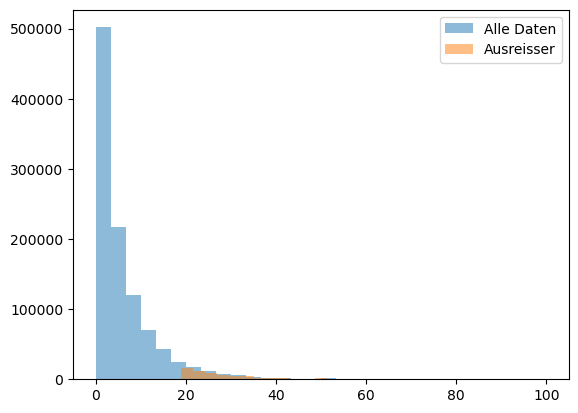

,AGS,Gemeinde,Geschlecht,Altersgruppe_LB,Anzahl_LB,Jahr,Anzahl_Bevoelkerung,SGB2-Quote (%)
304162,1054076,Leck,m,6 bis unter 15 Jahren,57.416667,2016,304.0,18.887061
248311,13076128,"Sternberg, Stadt",m,25 bis unter 65 Jahren,230.25,2015,1219.0,18.888433
192490,12071044,"Döbern, Stadt",w,6 bis unter 15 Jahren,19.833333,2015,105.0,18.888889
555279,3361003,Dörverden,w,3 bis unter 6 Jahren,19.833333,2018,105.0,18.888889
42350,16074012,Crossen an der Elster,w,3 bis unter 6 Jahren,2.833333,2014,15.0,18.888889
455836,16073054,Mellenbach-Glasbach,w,6 bis unter 15 Jahren,2.833333,2017,15.0,18.888889
282045,16071048,Kromsdorf,w,unter 3 Jahren,2.833333,2016,15.0,18.888889
956637,13075022,Butzow,m,6 bis unter 15 Jahren,2.833333,2021,15.0,18.888889
860762,12062425,Sallgast,w,15 bis unter 18 Jahren,2.833333,2020,15.0,18.888889
819174,13075127,Spantekow,w,3 bis unter 6 Jahren,2.833333,2020,15.0,18.888889


In [32]:
# Histogramm der "SGB2-Quote (%)" Werte erstellen, das die Ausreisser hervorhebt
# Tabellenkopf mit den niedrigsten als Ausreissern identifizierten Werten anzeigen
plt.hist(stacked_lb_bev["SGB2-Quote (%)"], bins=30, alpha=0.5, label='Alle Daten')
plt.hist(outliers["SGB2-Quote (%)"], bins=30, alpha=0.5, label='Ausreisser')
plt.legend(loc='upper right')
plt.show()
outliers.sort_values('SGB2-Quote (%)', ascending=True).head(10)

#### ---> Identifikation auf Grundlage des IQR scheint nicht geeignet, da auch plausible Werte ab 18% als Ausreisser identifiziert werden...

In [33]:
# Alternative: Eigenen Schwellenwert bestimmen
threshold = 40
outliers = stacked_lb_bev[stacked_lb_bev["SGB2-Quote (%)"] > threshold]
num_outliers = len(outliers)
total_values = len(stacked_lb_bev)
outlier_percentage = (num_outliers / total_values) * 100
print("Prozentanteil der Ausreisser mit %-Werten ueber", threshold, "%:", outlier_percentage)
print("Anzahl der Ausreisser:", num_outliers)
outliers.sort_values('SGB2-Quote (%)', ascending=True).head(10)

Prozentanteil der Ausreisser mit %-Werten ueber 40 %: 0.6897366565688652
Anzahl der Ausreisser: 7122


,AGS,Gemeinde,Geschlecht,Altersgruppe_LB,Anzahl_LB,Jahr,Anzahl_Bevoelkerung,SGB2-Quote (%)
160850,15082180,"Köthen (Anhalt), Stadt",m,3 bis unter 6 Jahren,118.416667,2015,296.0,40.005631
137882,12068264,"Kyritz, Stadt",m,unter 3 Jahren,44.416667,2015,111.0,40.015015
938976,5113000,"Essen, Stadt",w,3 bis unter 6 Jahren,2726.916667,2021,6814.0,40.019323
393116,3405000,"Wilhelmshaven, Stadt",m,unter 3 Jahren,338.25,2017,845.0,40.029586
661919,1051044,"Heide, Stadt",w,unter 3 Jahren,100.083333,2019,250.0,40.033333
522815,3252006,"Hameln, Stadt",m,unter 3 Jahren,280.25,2018,700.0,40.035714
149347,13075079,Löcknitz,w,unter 3 Jahren,16.416667,2015,41.0,40.04065
684540,3405000,"Wilhelmshaven, Stadt",w,3 bis unter 6 Jahren,316.333333,2019,790.0,40.042194
293762,1058135,"Rendsburg, Stadt",w,3 bis unter 6 Jahren,139.75,2016,349.0,40.04298
561907,12066304,"Senftenberg, Stadt",w,3 bis unter 6 Jahren,100.916667,2018,252.0,40.046296


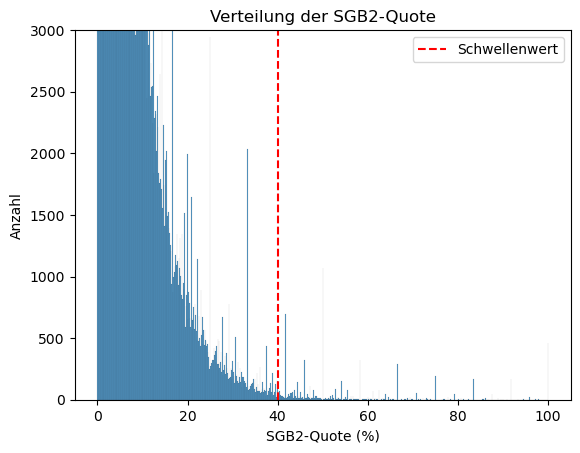

In [34]:
sns.histplot(stacked_lb_bev["SGB2-Quote (%)"])
plt.axvline(x=threshold, color='r', linestyle='--', label='Schwellenwert')
plt.legend()
plt.xlabel("SGB2-Quote (%)")
plt.ylabel("Anzahl")
plt.title("Verteilung der SGB2-Quote")
plt.ylim(0, 3000)
plt.show()

### 3.6 Moegliche bins fuer die Darstellung der Daten auf eingefaerbter Karte pruefen

__Quantile-Methode__: Bei dieser Methode werden die Bins so gewaehlt, dass jedes Intervall die gleiche Anzahl von Datenpunkten enthaelt. Das ist nuetzlich, wenn man will, dass die Farben auf der Karte gleichmaessig verteilt sind. Allerdings koennen kleine Unterschiede in den Daten zu grossen Unterschieden in den Bins fuehren, wenn die Daten eng beieinander liegen.

Anm.: irgendwas laeuft bei der Berechnung falsch, die Bins sollten doch alle dieselbe Anzahl an Datenpunkten enthalten?!

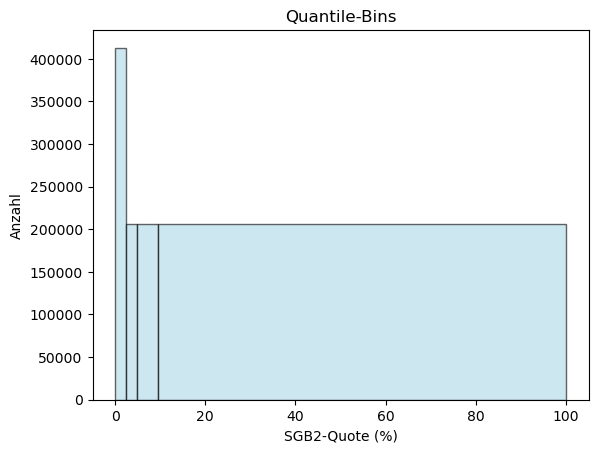

Bin 1: 0.00-0.00, Anzahl: 0
Bin 2: 0.00-2.35, Anzahl: 412997
Bin 3: 2.35-4.89, Anzahl: 206544
Bin 4: 4.89-9.49, Anzahl: 206492
Bin 5: 9.49-100.00, Anzahl: 206073


In [35]:
# Anzahl der Bins
num_bins = 5

# Quantile berechnen
quantiles = np.linspace(0, 1, num_bins + 1)
bin_edges = np.quantile(stacked_lb_bev['SGB2-Quote (%)'], quantiles)

# Histogramm erstellen
plt.hist(stacked_lb_bev['SGB2-Quote (%)'], bins=bin_edges, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Quantile-Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(num_bins):
    bin_range = f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}'
    count = ((stacked_lb_bev['SGB2-Quote (%)'] >= bin_edges[i]) & (stacked_lb_bev['SGB2-Quote (%)'] < bin_edges[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Gleichmaessige Intervalle__: Hierbei wird der gesamte Bereich der Daten in gleich grosse Intervalle unterteilt. Das ist einfach zu verstehen und zu implementieren, kann jedoch dazu fuehren, dass viele Datenpunkte in ein oder zwei Bins fallen, wenn die Daten stark ungleich verteilt sind.

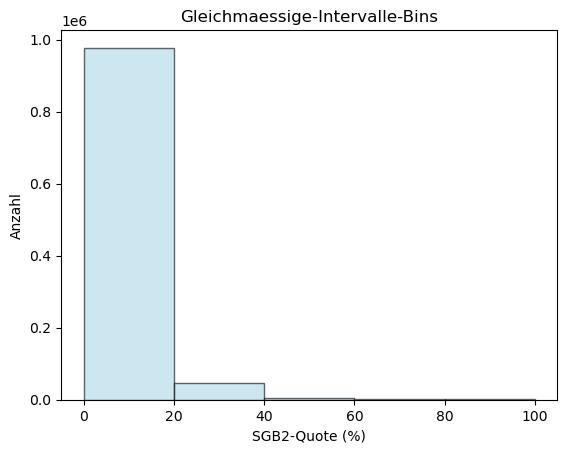

Bin 1: 0.00-20.00, Anzahl: 977796
Bin 2: 20.00-40.00, Anzahl: 47529
Bin 3: 40.00-60.00, Anzahl: 5166
Bin 4: 60.00-80.00, Anzahl: 1108
Bin 5: 80.00-100.00, Anzahl: 507


In [36]:
# Anzahl der Bins
num_bins = 5

# Gleichmaessige Intervalle berechnen
bin_edges = np.linspace(stacked_lb_bev['SGB2-Quote (%)'].min(), stacked_lb_bev['SGB2-Quote (%)'].max(), num_bins + 1)

# Histogramm erstellen
plt.hist(stacked_lb_bev['SGB2-Quote (%)'], bins=bin_edges, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Gleichmaessige-Intervalle-Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(num_bins):
    bin_range = f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}'
    count = ((stacked_lb_bev['SGB2-Quote (%)'] >= bin_edges[i]) & (stacked_lb_bev['SGB2-Quote (%)'] < bin_edges[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Standardabweichung__: Hierbei werden Bins basierend auf der statistischen Standardabweichung der Daten erstellt. Dies kann hilfreich sein, um zu sehen, welche Datenpunkte signifikant vom Durchschnitt abweichen.

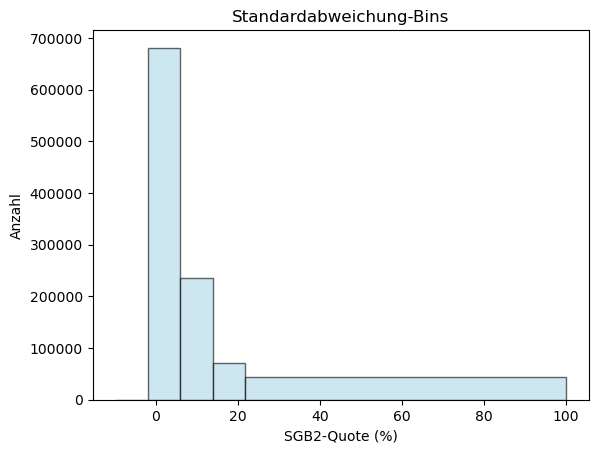

Bin 1: -9.97--2.03, Anzahl: 0
Bin 2: -2.03-5.90, Anzahl: 680871
Bin 3: 5.90-13.84, Anzahl: 236173
Bin 4: 13.84-21.77, Anzahl: 71551
Bin 5: 21.77-100.00, Anzahl: 43511


In [37]:
# Anzahl der Bins
num_bins = 5

# Standardabweichung berechnen
mean = stacked_lb_bev['SGB2-Quote (%)'].mean()
std = stacked_lb_bev['SGB2-Quote (%)'].std()
bin_edges = [mean - 2*std, mean - std, mean, mean + std, mean + 2*std, stacked_lb_bev['SGB2-Quote (%)'].max()]

# Histogramm erstellen
plt.hist(stacked_lb_bev['SGB2-Quote (%)'], bins=bin_edges, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Standardabweichung-Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(len(bin_edges)-1):
    bin_range = f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}'
    count = ((stacked_lb_bev['SGB2-Quote (%)'] >= bin_edges[i]) & (stacked_lb_bev['SGB2-Quote (%)'] < bin_edges[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Benutzerdefinierte Bins__:  Hier kann der Benutzer die Bins manuell festlegen, auf Grundlage seines Wissens ueber die Struktur der Daten, fachlicher Erwaegungen, seiner Anforderungen an die Visualisierung etc....

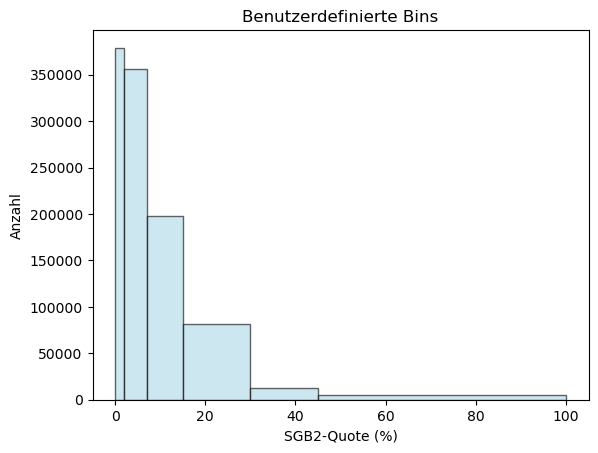

Bin 1: 0-2, Anzahl: 379013
Bin 2: 2-7, Anzahl: 356125
Bin 3: 7-15, Anzahl: 198081
Bin 4: 15-30, Anzahl: 81133
Bin 5: 30-45, Anzahl: 12977
Bin 6: 45-100, Anzahl: 4777


In [38]:
# Benutzerdefinierte Bins festlegen
custom_bins = [0, 2, 7, 15, 30, 45, 100]

# Histogramm erstellen
plt.hist(stacked_lb_bev['SGB2-Quote (%)'], bins=custom_bins, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Benutzerdefinierte Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(len(custom_bins)-1):
    bin_range = f'{custom_bins[i]}-{custom_bins[i+1]}'
    count = ((stacked_lb_bev['SGB2-Quote (%)'] >= custom_bins[i]) & (stacked_lb_bev['SGB2-Quote (%)'] < custom_bins[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Natural-Breaks Bins__:  Die Methode Natural Breaks klassifiziert die Datenpunkte in Klassen basierend auf natuerlichen Gruppen in den Daten selbst. Sie versucht, die Varianz innerhalb der Gruppen zu minimieren und die Varianz zwischen den Gruppen zu maximieren. Daher kann es sein, dass die unteren oder oberen Grenzen der Daten nicht beruecksichtigt werden, wenn sie nicht zu den natuerlichen "Bruechen" in den Daten beitragen (in unserem Fall an der unteren Grenze...)

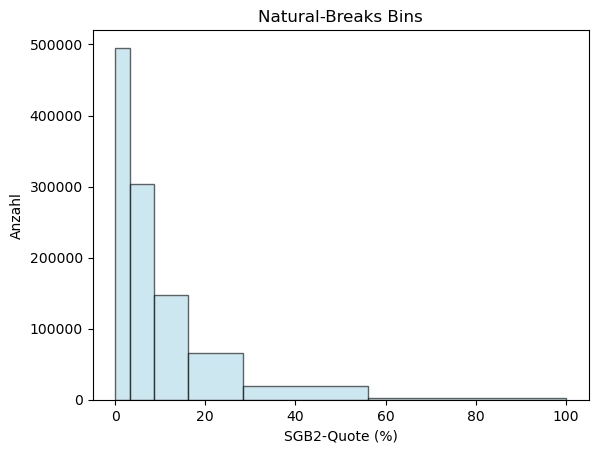

Bin 1: 0.0-3.248956971168821, Anzahl: 273894
Bin 2: 3.248956971168821-8.580791867308708, Anzahl: 303234
Bin 3: 8.580791867308708-16.15702479338843, Anzahl: 147349
Bin 4: 16.15702479338843-28.460451977401103, Anzahl: 65397
Bin 5: 28.460451977401103-56.150793650793574, Anzahl: 18666
Bin 6: 56.150793650793574-100.0, Anzahl: 2517


In [39]:
# Extrahieren der Werte aus der Spalte 'SGB2-Quote (%)'
data = stacked_lb_bev['SGB2-Quote (%)'].values

# Berechnen der Bins mit der NaturalBreaks-Methode
classifier = NaturalBreaks(data, k=6)
breaks = classifier.bins
breaks = np.insert(breaks, 0, 0)

# Erstellen des Histogramms
plt.hist(data, bins=breaks, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Natural-Breaks Bins')
plt.show()

# Ausgabe der Bin-Ranges und der Anzahl der Werte in jedem Bin
for i in range(len(breaks)-1):
    print(f"Bin {i+1}: {breaks[i]}-{breaks[i+1]}, Anzahl: {((data > breaks[i]) & (data <= breaks[i+1])).sum()}")

__FisherJenksSampled__

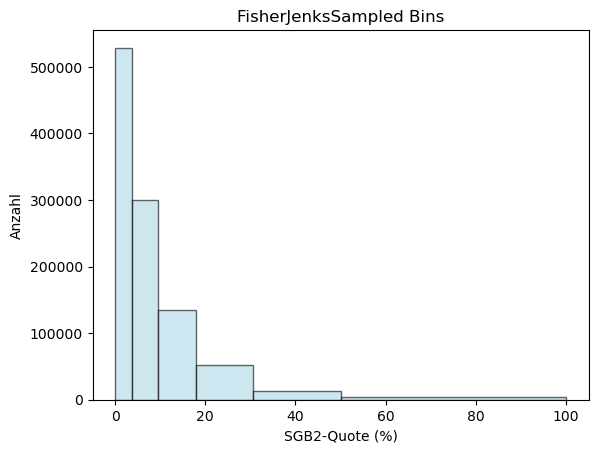

Bin 1: 0.0-3.6458333333333313, Anzahl: 307400
Bin 2: 3.6458333333333313-9.58333333333335, Anzahl: 300071
Bin 3: 9.58333333333335-18.010752688172033, Anzahl: 135211
Bin 4: 18.010752688172033-30.69105691056909, Anzahl: 51502
Bin 5: 30.69105691056909-50.0, Anzahl: 13733
Bin 6: 50.0-100.0, Anzahl: 3140


In [40]:
# Extrahieren der Werte aus der Spalte 'SGB2-Quote (%)'
data = stacked_lb_bev['SGB2-Quote (%)'].values

# Berechnen der Bins mit der FisherJenksSampled-Methode
classifier = FisherJenksSampled(data, pct=0.2, k=6)
bins = classifier.bins
bins = np.insert(bins, 0, 0)

# Erstellen des Histogramms
plt.hist(data, bins=bins, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('FisherJenksSampled Bins')
plt.show()

# Ausgabe der Bin-Ranges und der Anzahl der Werte in jedem Bin
for i in range(len(bins)-1):
    print(f"Bin {i+1}: {bins[i]}-{bins[i+1]}, Anzahl: {((data > bins[i]) & (data <= bins[i+1])).sum()}")

### 3.7 Testen, was passiert, wenn  alle Datenpunkte mit Bezugsgroeße > 100 entfernt werden: Wieviel bleibt uebrig, wie wirkt es sich auf Verteilung und moegliche Bins aus?

#### Anm.: Hier werden auf der kleinsten Aggregationsebene die Bezugsgroeßen > 100 entfernt. Eine "schonendere" Variante wuerde darin bestehen, in den Bevoelkerungsdaten (vor dem Merge) alle Gemeinden mit > 100 Einwohnern zu entfernen...

In [52]:
# Datensaetze erstellen
stacked_lb_bev_ue100 = stacked_lb_bev[stacked_lb_bev.Anzahl_Bevoelkerung > 25]
stacked_elb_schul_ue100 = stacked_elb_schul[stacked_elb_schul.arbeitsuchende_elb_insgesamt > 25]
stacked_elb_beruf_ue100 = stacked_elb_beruf[stacked_elb_beruf.arbeitsuchende_elb_insgesamt > 25]

In [53]:
# Berechnen, welcher Anteil der Datenpunkte entfernt wurde
# (gibt einen Eindruck, wie viele "weiße Flecken" auf der Karte zu erwarten sind)

num_rows_stacked_elb_beruf = stacked_elb_beruf.shape[0]
num_rows_stacked_elb_schul = stacked_elb_schul.shape[0]
num_rows_stacked_lb_bev = stacked_lb_bev.shape[0]

num_rows_stacked_elb_beruf_ue100 = stacked_elb_beruf_ue100.shape[0]
num_rows_stacked_elb_schul_ue100 = stacked_elb_schul_ue100.shape[0]
num_rows_stacked_lb_bev_ue100 = stacked_lb_bev_ue100.shape[0]

diff1 = num_rows_stacked_elb_beruf - num_rows_stacked_elb_beruf_ue100
diff2 = num_rows_stacked_elb_schul - num_rows_stacked_elb_schul_ue100
diff3 = num_rows_stacked_lb_bev - num_rows_stacked_lb_bev_ue100

remaining1 = num_rows_stacked_elb_beruf_ue100/num_rows_stacked_elb_beruf*100
remaining2 = num_rows_stacked_elb_schul_ue100/num_rows_stacked_elb_schul*100
remaining3 = num_rows_stacked_lb_bev_ue100/num_rows_stacked_lb_bev*100

print("In der Tabelle 'stacked_elb_beruf' wurden", diff1, "Datenpunkte entfernt. Es sind noch", remaining1, "% der Ausgangswerte enthalten." )
print("In der Tabelle 'stacked_elb_schul' wurden", diff2, "Datenpunkte entfernt. Es sind noch", remaining2, "% der Ausgangswerte enthalten." )
print("In der Tabelle 'stacked_lb_bev' wurden", diff3, "Datenpunkte entfernt. Es sind noch", remaining3, "% der Ausgangswerte enthalten." )


In der Tabelle 'stacked_elb_beruf' wurden 445844 Datenpunkte entfernt. Es sind noch 33.91888446876501 % der Ausgangswerte enthalten.
In der Tabelle 'stacked_elb_schul' wurden 668766 Datenpunkte entfernt. Es sind noch 33.91888446876501 % der Ausgangswerte enthalten.
In der Tabelle 'stacked_lb_bev' wurden 358026 Datenpunkte entfernt. Es sind noch 65.32664192576179 % der Ausgangswerte enthalten.


#### --> kann nicht die Loesung sein, es gehen zu viele Werte verloren...

__Quantile-Methode__: Bei dieser Methode werden die Bins so gewaehlt, dass jedes Intervall die gleiche Anzahl von Datenpunkten enthaelt. Das ist nuetzlich, wenn man will, dass die Farben auf der Karte gleichmaessig verteilt sind. Allerdings koennen kleine Unterschiede in den Daten zu grossen Unterschieden in den Bins fuehren, wenn die Daten eng beieinander liegen.

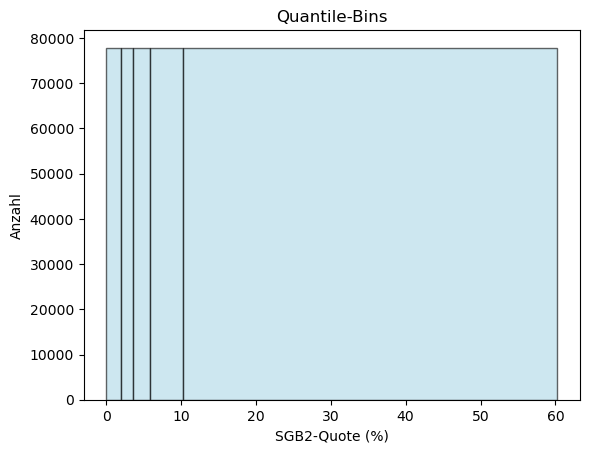

Bin 1: 0.00-2.02, Anzahl: 77846
Bin 2: 2.02-3.63, Anzahl: 77844
Bin 3: 3.63-5.90, Anzahl: 77851
Bin 4: 5.90-10.20, Anzahl: 77847
Bin 5: 10.20-60.23, Anzahl: 77847


In [44]:
# Anzahl der Bins
num_bins = 5

# Quantile berechnen
quantiles = np.linspace(0, 1, num_bins + 1)
bin_edges = np.quantile(stacked_lb_bev_ue100['SGB2-Quote (%)'], quantiles)

# Histogramm erstellen
plt.hist(stacked_lb_bev_ue100['SGB2-Quote (%)'], bins=bin_edges, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Quantile-Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(num_bins):
    bin_range = f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}'
    count = ((stacked_lb_bev_ue100['SGB2-Quote (%)'] >= bin_edges[i]) & (stacked_lb_bev_ue100['SGB2-Quote (%)'] < bin_edges[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Gleichmaessige Intervalle__: Hierbei wird der gesamte Bereich der Daten in gleich grosse Intervalle unterteilt. Das ist einfach zu verstehen und zu implementieren, kann jedoch dazu fuehren, dass viele Datenpunkte in ein oder zwei Bins fallen, wenn die Daten stark ungleich verteilt sind.

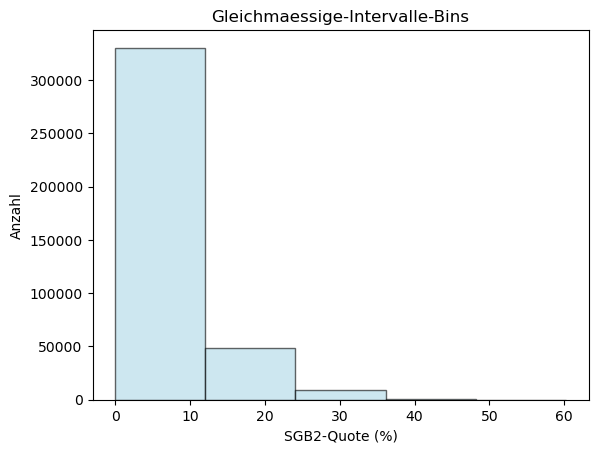

Bin 1: 0.00-12.05, Anzahl: 330541
Bin 2: 12.05-24.09, Anzahl: 48544
Bin 3: 24.09-36.14, Anzahl: 9032
Bin 4: 36.14-48.18, Anzahl: 1031
Bin 5: 48.18-60.23, Anzahl: 87


In [45]:
# Anzahl der Bins
num_bins = 5

# Gleichmaessige Intervalle berechnen
bin_edges = np.linspace(stacked_lb_bev_ue100['SGB2-Quote (%)'].min(), stacked_lb_bev_ue100['SGB2-Quote (%)'].max(), num_bins + 1)

# Histogramm erstellen
plt.hist(stacked_lb_bev_ue100['SGB2-Quote (%)'], bins=bin_edges, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Gleichmaessige-Intervalle-Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(num_bins):
    bin_range = f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}'
    count = ((stacked_lb_bev_ue100['SGB2-Quote (%)'] >= bin_edges[i]) & (stacked_lb_bev_ue100['SGB2-Quote (%)'] < bin_edges[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Standardabweichung__: Hierbei werden Bins basierend auf der statistischen Standardabweichung der Daten erstellt. Dies kann hilfreich sein, um zu sehen, welche Datenpunkte signifikant vom Durchschnitt abweichen.

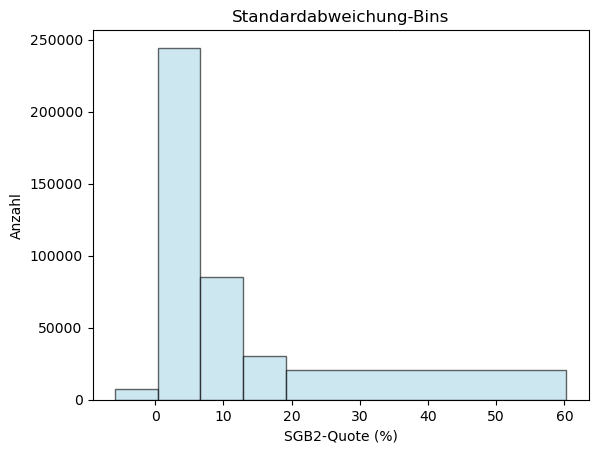

Bin 1: -5.87-0.39, Anzahl: 7748
Bin 2: 0.39-6.65, Anzahl: 244455
Bin 3: 6.65-12.91, Anzahl: 85513
Bin 4: 12.91-19.17, Anzahl: 30623
Bin 5: 19.17-60.23, Anzahl: 20896


In [46]:
# Anzahl der Bins
num_bins = 5

# Standardabweichung berechnen
mean = stacked_lb_bev_ue100['SGB2-Quote (%)'].mean()
std = stacked_lb_bev_ue100['SGB2-Quote (%)'].std()
bin_edges = [mean - 2*std, mean - std, mean, mean + std, mean + 2*std, stacked_lb_bev_ue100['SGB2-Quote (%)'].max()]

# Histogramm erstellen
plt.hist(stacked_lb_bev_ue100['SGB2-Quote (%)'], bins=bin_edges, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Standardabweichung-Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(len(bin_edges)-1):
    bin_range = f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}'
    count = ((stacked_lb_bev_ue100['SGB2-Quote (%)'] >= bin_edges[i]) & (stacked_lb_bev_ue100['SGB2-Quote (%)'] < bin_edges[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Benutzerdefinierte Bins__:  Hier kann der Benutzer die Bins manuell festlegen, auf Grundlage seines Wissens ueber die Struktur der Daten, fachlicher Erwaegungen, seiner Anforderungen an die Visualisierung etc....

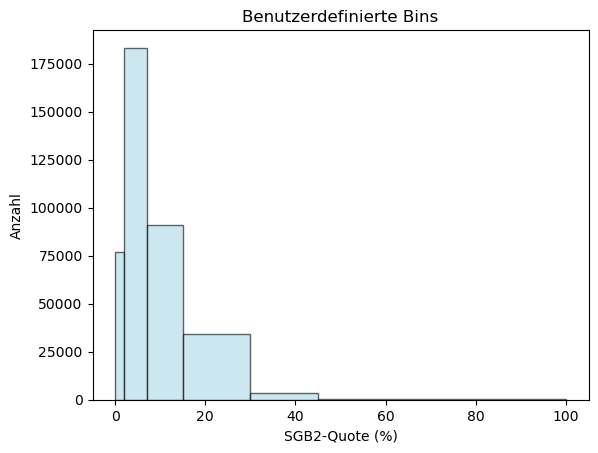

Bin 1: 0-2, Anzahl: 76845
Bin 2: 2-7, Anzahl: 183306
Bin 3: 7-15, Anzahl: 91199
Bin 4: 15-30, Anzahl: 34007
Bin 5: 30-45, Anzahl: 3707
Bin 6: 45-100, Anzahl: 172


In [47]:
# Benutzerdefinierte Bins festlegen
custom_bins = [0, 2, 7, 15, 30, 45, 100]

# Histogramm erstellen
plt.hist(stacked_lb_bev_ue100['SGB2-Quote (%)'], bins=custom_bins, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Benutzerdefinierte Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(len(custom_bins)-1):
    bin_range = f'{custom_bins[i]}-{custom_bins[i+1]}'
    count = ((stacked_lb_bev_ue100['SGB2-Quote (%)'] >= custom_bins[i]) & (stacked_lb_bev_ue100['SGB2-Quote (%)'] < custom_bins[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Natural-Breaks Bins__: Die Methode Natural Breaks klassifiziert die Datenpunkte in Klassen basierend auf natuerlichen Gruppen in den Daten selbst. Sie versucht, die Varianz innerhalb der Gruppen zu minimieren und die Varianz zwischen den Gruppen zu maximieren. Daher kann es sein, dass die unteren oder oberen Grenzen der Daten nicht beruecksichtigt werden, wenn sie nicht zu den natuerlichen "Bruechen" in den Daten beitragen (in diesem Fall an der unteren Grenze...)

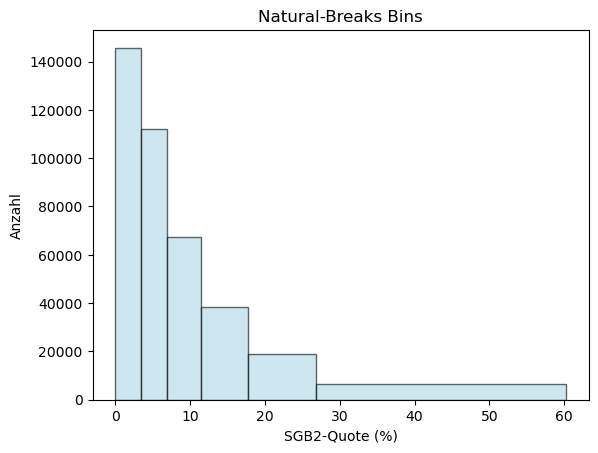

Bin 1: 0.0-3.405953667026766, Anzahl: 143466
Bin 2: 3.405953667026766-6.895280235988185, Anzahl: 112062
Bin 3: 6.895280235988185-11.47746243739566, Anzahl: 67465
Bin 4: 11.47746243739566-17.749529190207173, Anzahl: 38386
Bin 5: 17.749529190207173-26.798245614035, Anzahl: 18988
Bin 6: 26.798245614035-60.229400749063764, Anzahl: 6603


In [48]:
# Extrahieren der Werte aus der Spalte 'SGB2-Quote (%)'
data = stacked_lb_bev_ue100['SGB2-Quote (%)'].values

# Berechnen der Bins mit der NaturalBreaks-Methode
classifier = NaturalBreaks(data, k=6)
breaks = classifier.bins
breaks = np.insert(breaks, 0, 0)

# Erstellen des Histogramms
plt.hist(data, bins=breaks, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Natural-Breaks Bins')
plt.show()

# Ausgabe der Bin-Ranges und der Anzahl der Werte in jedem Bin
for i in range(len(breaks)-1):
    print(f"Bin {i+1}: {breaks[i]}-{breaks[i+1]}, Anzahl: {((data > breaks[i]) & (data <= breaks[i+1])).sum()}")

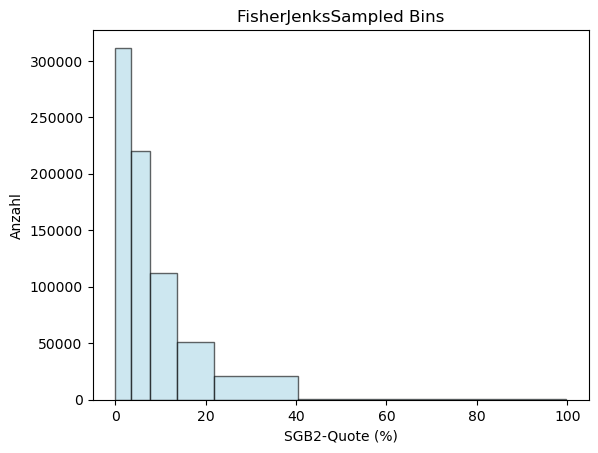

Bin 1: 0.0-3.4482758620689653, Anzahl: 260276
Bin 2: 3.4482758620689653-7.824222936763118, Anzahl: 219796
Bin 3: 7.824222936763118-13.657407407407405, Anzahl: 112471
Bin 4: 13.657407407407405-21.84551886792453, Anzahl: 51256
Bin 5: 21.84551886792453-40.447154471544756, Anzahl: 20770
Bin 6: 40.447154471544756-99.71264367816104, Anzahl: 798


In [44]:
# Extrahieren der Werte aus der Spalte 'SGB2-Quote (%)'
data = stacked_lb_bev_ue100['SGB2-Quote (%)'].values

# Berechnen der Bins mit der FisherJenksSampled-Methode
classifier = FisherJenksSampled(data, pct=0.2, k=6)
bins = classifier.bins
bins = np.insert(bins, 0, 0)

# Erstellen des Histogramms
plt.hist(data, bins=bins, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('FisherJenksSampled Bins')
plt.show()

# Ausgabe der Bin-Ranges und der Anzahl der Werte in jedem Bin
for i in range(len(bins)-1):
    print(f"Bin {i+1}: {bins[i]}-{bins[i+1]}, Anzahl: {((data > bins[i]) & (data <= bins[i+1])).sum()}")

In [50]:
classifier

FisherJenksSampled

   Interval       Count
-----------------------
[ 0.00,  4.68] | 196018
( 4.68,  9.97] | 112503
( 9.97, 17.62] |  54646
(17.62, 26.78] |  19441
(26.78, 60.23] |   6628

In [51]:
bins

array([ 0.        ,  4.6836983 ,  9.96628322, 17.6187118 , 26.77595628,
       60.22940075])

In [52]:
bins = np.insert(bins, 0, 0)
bins

array([ 0.        ,  0.        ,  4.6836983 ,  9.96628322, 17.6187118 ,
       26.77595628, 60.22940075])

### Bins-Spalte ergänzen

In [46]:
# Grenzen und Labels für die Bins (basierend auf FisherJenks) definieren
bins = [0, 3, 7.81, 14.81, 25.99, 58.33, 100]
labels = [1, 2, 3, 4, 5, 6]

# neue 'bins'-Spalte erstellen
stacked_lb_bev['bins'] = pd.cut(stacked_lb_bev['SGB2-Quote (%)'], bins=bins, labels=labels)

stacked_lb_bev.head()

,AGS,Gemeinde,Geschlecht,Altersgruppe_LB,Anzahl_LB,Jahr,Anzahl_Bevoelkerung,SGB2-Quote (%),bins
0,1001000,"Flensburg, Stadt",m,unter 3 Jahren,273.666667,2014,1087.0,25.176326,4
1,1002000,"Kiel, Landeshauptstadt",m,unter 3 Jahren,888.333333,2014,3284.0,27.050345,5
2,1003000,"Lübeck, Hansestadt",m,unter 3 Jahren,745.166667,2014,2802.0,26.594099,5
3,1004000,"Neumünster, Stadt",m,unter 3 Jahren,268.833333,2014,954.0,28.179595,5
4,1051001,Albersdorf,m,unter 3 Jahren,17,2014,54.0,31.481481,5


In [47]:
# Grenzen und Labels für die Bins (basierend auf FisherJenks) definieren
bins = [0, 3.4, 7.8, 13.7, 21.8, 40.4, 100]
labels = [1, 2, 3, 4, 5, 6]

# neue 'bins'-Spalte erstellen
stacked_lb_bev_ue100['bins'] = pd.cut(stacked_lb_bev_ue100['SGB2-Quote (%)'], bins=bins, labels=labels)

stacked_lb_bev_ue100.head()

C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_23044\1646345990.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stacked_lb_bev_ue100['bins'] = pd.cut(stacked_lb_bev_ue100['SGB2-Quote (%)'], bins=bins, labels=labels)


,AGS,Gemeinde,Geschlecht,Altersgruppe_LB,Anzahl_LB,Jahr,Anzahl_Bevoelkerung,SGB2-Quote (%),bins
0,1001000,"Flensburg, Stadt",m,unter 3 Jahren,273.666667,2014,1087.0,25.176326,5
1,1002000,"Kiel, Landeshauptstadt",m,unter 3 Jahren,888.333333,2014,3284.0,27.050345,5
2,1003000,"Lübeck, Hansestadt",m,unter 3 Jahren,745.166667,2014,2802.0,26.594099,5
3,1004000,"Neumünster, Stadt",m,unter 3 Jahren,268.833333,2014,954.0,28.179595,5
4,1051001,Albersdorf,m,unter 3 Jahren,17,2014,54.0,31.481481,5


### Problem beheben, dass durch 7-stellige AGS entsteht
erstmal nur mit SGB-II Tabelle testen

In [48]:
# Spalte "AGS" als String definieren
stacked_lb_bev_ue100["AGS"] = stacked_lb_bev_ue100["AGS"].astype(str)

# "0" vor den Einträgen mit genau 7 Zeichen hinzufügen
stacked_lb_bev_ue100["AGS"] = stacked_lb_bev_ue100["AGS"].apply(lambda x: '0' + x if len(x) == 7 else x)

C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_23044\3310119617.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stacked_lb_bev_ue100["AGS"] = stacked_lb_bev_ue100["AGS"].astype(str)
C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_23044\3310119617.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stacked_lb_bev_ue100["AGS"] = stacked_lb_bev_ue100["AGS"].apply(lambda x: '0' + x if len(x) == 7 else x)


In [ ]:
# Spalte "AGS" als String definieren
stacked_lb_bev["AGS"] = stacked_lb_bev["AGS"].astype(str)

# "0" vor den Einträgen mit genau 7 Zeichen hinzufügen
stacked_lb_bev["AGS"] = stacked_lb_bev["AGS"].apply(lambda x: '0' + x if len(x) == 7 else x)

In [60]:
# Prüfen, ob alles funktioniert hat:

# Filtern des DataFrames nach Zeilen, in denen die Länge der Spalte "AGS" genau 7 ist
filtered_df = stacked_lb_bev[stacked_lb_bev["AGS"].str.len() == 7]

# Zählen der Anzahl von Zeilen im gefilterten DataFrame
count = len(filtered_df)

# Ausgabe der Anzahl
print(count)

0


In [61]:
stacked_lb_bev.head()

,AGS,Gemeinde,Geschlecht,Altersgruppe_LB,Anzahl_LB,Jahr,Anzahl_Bevoelkerung,SGB2-Quote (%),bins
0,01001000,"Flensburg, Stadt",m,unter 3 Jahren,273.666667,2014,1087.0,25.176326,4
1,01002000,"Kiel, Landeshauptstadt",m,unter 3 Jahren,888.333333,2014,3284.0,27.050345,5
2,01003000,"Lübeck, Hansestadt",m,unter 3 Jahren,745.166667,2014,2802.0,26.594099,5
3,01004000,"Neumünster, Stadt",m,unter 3 Jahren,268.833333,2014,954.0,28.179595,5
4,01051001,Albersdorf,m,unter 3 Jahren,17,2014,54.0,31.481481,5


### 4. Tabellen exportieren als Excel und CSV

In [52]:
# DataFrame stacked_elb_schul speichern
stacked_elb_schul.to_excel('elb_quote_schul.xlsx', index=False)
stacked_elb_schul.to_csv('elb_quote_schul.csv', index=False)

stacked_elb_schul_ue100.to_excel('elb_quote_schul_ue100.xlsx', index=False)
stacked_elb_schul_ue100.to_csv('elb_quote_schul_ue100.csv', index=False)

# DataFrame stacked_elb_beruf speichern
stacked_elb_beruf.to_excel('elb_quote_beruf.xlsx', index=False)
stacked_elb_beruf.to_csv('elb_quote_beruf.csv', index=False)

stacked_elb_beruf_ue100.to_excel('elb_quote_beruf_ue100.xlsx', index=False)
stacked_elb_beruf_ue100.to_csv('elb_quote_beruf_ue100.csv', index=False)

# DataFrame stacked_lb_bev speichern
stacked_lb_bev.to_excel('sgb2_quote.xlsx', index=False)
stacked_lb_bev.to_csv('sgb2_quote.csv', index=False)

stacked_lb_bev_ue100.to_excel('sgb2_quote_ue100.xlsx', index=False)
stacked_lb_bev_ue100.to_csv('sgb2_quote_ue100.csv', index=False)

In [53]:
stacked_lb_bev["SGB2-Quote (%)"].describe()

count     1032568.0
unique     236863.0
top             0.0
freq       221511.0
Name: SGB2-Quote (%), dtype: float64

In [62]:
stacked_lb_bev.to_excel('sgb2_quote.xlsx', index=False)


In [49]:
stacked_lb_bev_ue100.to_excel('sgb2_quote_ue100.xlsx', index=False)
